In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os, pickle
# sys.path.insert(0, os.path.abspath('../..'))
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D
from keras import regularizers
from keras import backend as K
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import scipy
print ("Using TF:", tf.__version__)
print ("Using Keras:", keras.__version__)

# Import DASP
from dasp import DASP

#Import DeepLift
# Installation instructions: https://github.com/kundajelab/deeplift
import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc
from deeplift.util import compile_func

# Import Deep Explain (for Grad * Input, Integrated Gradients and Occlusion implementations)
# Installation instructions: https://github.com/marcoancona/DeepExplain
from deepexplain.tensorflow import DeepExplain

Using TensorFlow backend.


Using TF: 1.15.0
Using Keras: 2.2.4
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.



In [2]:
# Build and train a network.

np.random.seed(15) # for riproducibility

SKIP_TRAIN = False
saved_model_file = '.model.h5'
saved_model_weights_file = '.model_weights.h5'

batch_size = 64
epochs = 1000 #ing early stopping

# Load data from CSV
data = np.loadtxt(open("select_data.csv", "rb"), delimiter=",", skiprows=1).astype(np.float32)

np.random.shuffle(data)
data_y = data[:, 1]
data_x = data[:, 2:]

In [3]:
scaler = MinMaxScaler(feature_range=(-1, 1))
print(scaler.fit(data_x))
data_x = scaler.transform(data_x)

assert np.isnan(data_x).any() == False
assert np.isnan(data_y).any() == False


print (data_x.shape)
x_test = data_x[:880]
y_test = data_y[:880]
x_train = data_x[880:]
y_train = data_y[880:]


print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print (y_train)
activation = 'relu'

if SKIP_TRAIN:
    model = load_model(saved_model_file)
else:
    model = Sequential()
    model.add(Dense(14, input_shape=(x_train.shape[1],), activation=activation, name='dense_1'))
    model.add(Dense(28, activation=activation, name='dense_2'))
    model.add(Dense(28, activation=activation, name='dense_3'))
    model.add(Dense(14, activation=activation, name='dense_4'))
#     model.add(Dropout(0.2))
#     model.add(Dense(64, activation=activation, name='dense_2'))
#     model.add(Dropout(0.2))
    model.add(Dense(1, name='dense_5'))
    
#     stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1)

    model.compile(loss=keras.losses.mean_squared_error,
                  optimizer=keras.optimizers.adam(),
                  metrics=['mae'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
#               callbacks=[stop],
              validation_data=(x_test, y_test))
    model.save(saved_model_file)
    model.save_weights(saved_model_weights_file)
print ("Done")
model.evaluate(x_test, y_test)

MinMaxScaler(feature_range=(-1, 1))
(586672, 14)
x_train shape: (585792, 14)
585792 train samples
880 test samples
[ 0. 17. 50. ... 17. 41. 21.]











Done
880/880 [==============================] - 0s 31us/step


[169.69954612038353, 9.9936241496693]

In [4]:
xs = x_test[0:100]
ys = y_test[0:100]

a_intgrad = np.zeros_like(xs)
a_res = np.zeros_like(xs)
a_rc = np.zeros_like(xs)
a_occlusion = np.zeros_like(xs)
a_dasp = np.zeros_like(xs)
a_exact = np.zeros_like(xs)

### Use Deep Shapley propagation to compute approximate Shapley Values.
Notice that this requires to convert our original model into a propababilistic one. We provide probabilistic layers for this.
Also, this will require O(c*n) evaluations of the probabilistic network, where n is the number of input features and c is the number of coalition sizes to be tested (ideally c = n)

In [5]:
# Init DASP
dasp = DASP(model)
# Get model description (optional)
dasp.model_summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 14)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 14)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_1 (ProbDenseInput)        (None, 14, 4)        210         input_1[0][0]                    
                                                                 input_2[0][0]                    
          

In [6]:
# Run DASP with 18 (=n_input_features) coalition sizes
a_dasp = dasp.run(xs, 14)

### Use DeepExplain framework to compute Integrated Gradients and Occlusion

In [7]:
%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.output)
    target_tensor = fModel(input_tensor)
    
    a_intgrad = de.explain('intgrad', target_tensor, input_tensor, xs)
    a_occlusion = de.explain('occlusion', target_tensor, input_tensor, xs)
    intgrads = [(k, de.explain('intgrad', target_tensor, input_tensor, xs, steps=k)) for k in [1, 2, 4, 8, 16, 32, 64, 128]]
    print ("Done")

Wall time: 0 ns
Done


### DeepLIFT

In [8]:
%%time
# Compute DeepLift attributions
revealcancel_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)

    
    
rescale_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.Rescale)

revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-1)
rescale_func = rescale_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-1)

a_rc = np.array([np.array(revealcancel_func(
                task_idx=0,
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x in xs])

a_res = np.array([np.array(rescale_func(
                task_idx=0,
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x in xs])
print (a_rc.shape)
a_rc = a_rc[:, 0, ...]
a_res = a_res[:, 0, ...]

nonlinear_mxts_mode is set to: RevealCancel


C:\Users\f9207\anaconda3\envs\py36\lib\site-packages\deeplift\conversion\kerasapi_conversion.py:359: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  str_data = h5py.File(h5_file).attrs["model_config"]
C:\Users\f9207\anaconda3\envs\py36\lib\site-packages\deeplift\conversion\kerasapi_conversion.py:366: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  model_weights = h5py.File(h5_file)


nonlinear_mxts_mode is set to: Rescale



(100, 1, 14)
Wall time: 1min 39s


### Exact Shapley Values
Since there are only 18 input features, in this case it is possible to compute the exact Shapley Values in reasonable time.

In [9]:
%%time
from utils.exact_shapley import compute_shapley
a_exact = np.array([compute_shapley(xx, lambda x: model.predict(np.array(x)).sum(-1)) for xx in xs])

Wall time: 2min 26s


In [10]:
attributions = [
    ('Integrated\nGradients',      a_intgrad.reshape(xs.shape)), 
    ('DL\n(Rescale)',              a_res.reshape(xs.shape)), 
    ('DL\n(RevCancel)',            a_rc.reshape(xs.shape)), 
    ('Occlusion',                  a_occlusion.reshape(xs.shape)), 
    ('DASP (Ours)',                a_dasp.reshape(xs.shape)), 
    ('GT',                         a_exact.reshape(xs.shape))
]

In [11]:
from skimage import feature, transform
import numpy as np
import matplotlib.pyplot as plt
import scipy
import datetime
import os
from matplotlib.ticker import FormatStrFormatter


COLORS = ["#4e79a7",
          "#59a14f",
          "#9c755f",
          "#edc948",
          "#bab0ac",
          "#e15759",
          "#b07aa1",
          "#f28e2b"]


def color_for_label(label):
    l = label.lower()
    if "integrated" in l:
        return COLORS[0]
    elif "occlusion" in l:
        return COLORS[1]
    elif "revcancel" in l:
        return COLORS[2]
    elif "mix" in l:
        return "#666666"
    elif "rescale" in l:
        return COLORS[5]
    elif "ours" in l or "dasp" in l:
        return "orange"
    elif "sampling" in l:
        return COLORS[6]
    else:
        return "#FFFFFF"


def _ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def get_plot_filename(plot_name, experiment_name):
    folder = "./results/" + experiment_name + "/"
    _ensure_dir(folder)
    t = datetime.datetime.now().isoformat()[:-7]
    return folder + plot_name + "_" + experiment_name + ".pdf"


def _isiterable(p_object):
    try:
        it = iter(p_object)
    except TypeError:
        return False
    return True


def plot(data, xi=None, cmap='RdBu_r', axis=plt, percentile=100, dilation=3.0, alpha=0.8):
    dx, dy = 0.05, 0.05
    xx = np.arange(0.0, data.shape[1], dx)
    yy = np.arange(0.0, data.shape[0], dy)
    xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
    extent = xmin, xmax, ymin, ymax
    cmap_xi = plt.get_cmap('Greys_r')
    cmap_xi.set_bad(alpha=0)
    overlay = None
    if xi is not None:
        # Compute edges (to overlay to heatmaps later)
        xi_greyscale = xi if len(xi.shape) == 2 else np.mean(xi, axis=-1)
        in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
        edges = feature.canny(in_image_upscaled).astype(float)
        edges[edges < 0.5] = np.nan
        edges[:5, :] = np.nan
        edges[-5:, :] = np.nan
        edges[:, :5] = np.nan
        edges[:, -5:] = np.nan
        overlay = edges

    abs_max = np.percentile(np.abs(data), percentile)
    abs_min = abs_max

    if len(data.shape) == 3:
        data = np.mean(data, 2)
    axis.imshow(data, extent=extent, interpolation='none', cmap=cmap, vmin=-abs_min, vmax=abs_max)
    if overlay is not None:
        axis.imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
    axis.axis('off')
    return axis


def plot_attribution_maps(name, xs, attributions, names, idxs=None, percentile=100, dilation=3.0, alpha=0.8, show_original=False):
    if idxs is None:
        idxs = list(range(len(attributions[0])))
    if show_original:
        names.insert(0, 'Input')
    rows = len(idxs)
    cols = len(names)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 2*rows))
    for ax, col in zip(axes[0] if _isiterable(axes[0]) else axes, names):
        ax.set_title(col, fontsize= 14)

    for i, idx in enumerate(idxs):
        if show_original:
            ax = axes[i, 0] if _isiterable(axes[0]) else axes[0]
            ax.axis('off')
            ax.imshow(xs[idx])

        for j, attribution in enumerate(attributions):
            if show_original:
                j += 1
            ax = axes[i, j] if _isiterable(axes[0]) else axes[j]
            attribution_map = attribution[idx]
            original_sample = xs[idx]
            plot(attribution_map, original_sample, axis=ax, percentile=percentile, dilation=dilation, alpha=alpha)
    fig.tight_layout()
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.2)

    plt.show()
#     print(get_plot_filename('maps', name))
#     return fig
    fig.savefig(get_plot_filename('maps', name), bbox_inches = "tight")


def _compare_attributions(attributions, metric='mse'):
    n = attributions[0].shape[0]
    values = np.zeros((len(attributions), len(attributions), n))

    for i, a1 in enumerate(attributions):
        for j, a2 in enumerate(attributions):
            for idx in range(n):
                if i >= j:
                    x1 = np.array(a1[idx]).reshape(-1)
                    x2 = np.array(a2[idx]).reshape(-1)
                    v = np.nan
                    if metric == 'mse':
                        v = (np.mean((x1-x2)**2.0))**0.5
                    elif metric == 'corr':
                        v = scipy.stats.spearmanr(x1, x2)[0]
                    values[i, j, idx] = v
                    values[j, i, idx] = values[i, j, idx, ]
    return values


def _plot_boxplot(plot_data, permuted_names, yaxis, experiment_name):
    fig, ax = plt.subplots(figsize=(6, 3))
    bplot = ax.boxplot(plot_data, showfliers=False, patch_artist=True, medianprops=dict(color="#FF0000AA"), )
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # fill with colors
    for bplot in (bplot, ):
        for patch, name in zip(bplot['boxes'], permuted_names):
            patch.set_facecolor(color_for_label(name))

    ## change color and linewidth of the whiskers
    for whisker in bplot['whiskers']:
        whisker.set(color='#222222', linewidth=1)

    ## change color and linewidth of the caps
    for cap in bplot['caps']:
        cap.set(color='#222222', linewidth=1)

    # Set the borders to a given color...
    ax.tick_params(color="#666666", labelcolor="#666666")
    for spine in ax.spines.values():
        spine.set_edgecolor("#666666")

    plt.ylabel(yaxis)
    plt.tick_params(color="#222222", labelcolor="#222222")
    ax.set_xticklabels(permuted_names,rotation=0, fontsize=12)
    plt.subplots_adjust(left=0.1, bottom=0.2, right=1, top=0.95, wspace=0.0, hspace=0.0)
    fig.savefig(get_plot_filename(yaxis.split(" ")[0].lower(), experiment_name))


def plot_mse_comparison(name, attributions, names, gt_idx=None):

    plot_data = _compare_attributions(attributions, metric='mse')
    plot_data = plot_data[gt_idx, :, :]

    permutation = np.argsort(-np.mean(plot_data, 1))

    plot_data = plot_data[permutation]

    permuted_names = [names[i] for i in permutation]
    gt_permuted_index = permuted_names.index(names[gt_idx])

    plot_data = plot_data.tolist()
    plot_data.pop(gt_permuted_index)
    permuted_names.pop(gt_permuted_index)

    _plot_boxplot(plot_data, permuted_names, 'RMSE', name)


def plot_correlation_comparison(name, attributions, names, gt_idx=None):

    plot_data = _compare_attributions(attributions, metric='corr')
    plot_data = plot_data[gt_idx, :, :]

    permutation = np.argsort(np.mean(plot_data, 1))

    plot_data = plot_data[permutation]

    permuted_names = [names[i] for i in permutation]
    gt_permuted_index = permuted_names.index(names[gt_idx])

    plot_data = plot_data.tolist()
    plot_data.pop(gt_permuted_index)
    permuted_names.pop(gt_permuted_index)

    _plot_boxplot(plot_data, permuted_names, "Spearman's rank correlation", name)


C:\Users\f9207\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:67: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Greys_r"))
C:\Users\f9207\anaconda3\envs\py36\lib\site-packages\matplotlib\image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\f9207\anaconda3\envs\py36\lib\site-packages\matplotlib\image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\f9207\anaconda3\envs\py36\lib\site-packages\matplotlib\image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


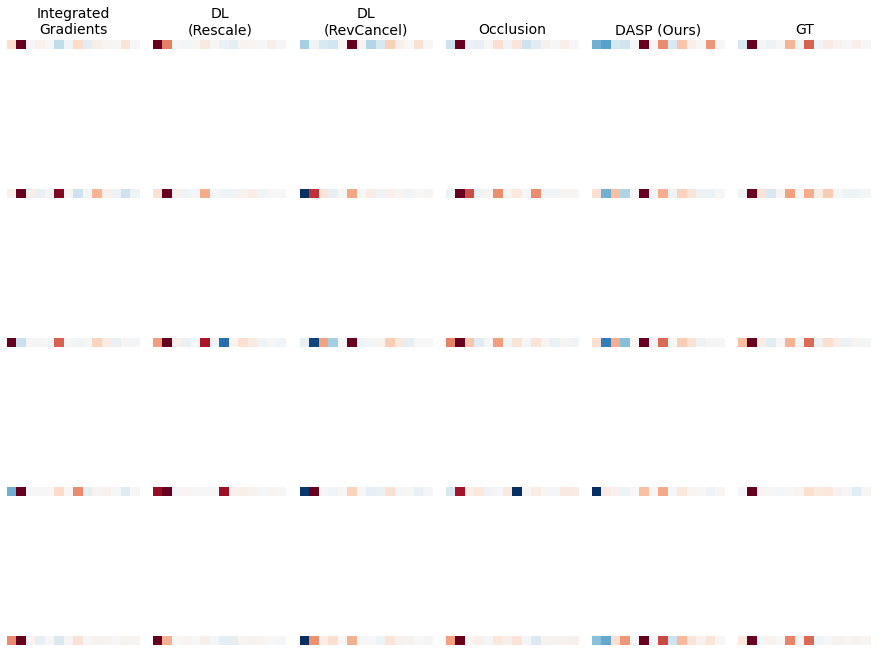

<string>:6: UserWarning: Warning: converting a masked element to nan.
C:\Users\f9207\anaconda3\envs\py36\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


In [12]:
# Plot attributions
%matplotlib inline
# from utils.utils import plot_attribution_maps

# Plot all
fig = plot_attribution_maps("spotifier", 
                      np.ones_like(xs).reshape(-1, 1, 14), 
                      [x[1].reshape(-1, 1, 14) for x in attributions],
                      [x[0] for x in attributions],
                      percentile=100,
                      show_original=False,
                      dilation=2,
                      alpha=0.3,
                      idxs=range(5))


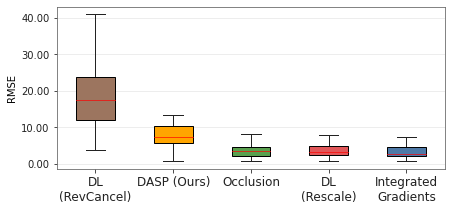

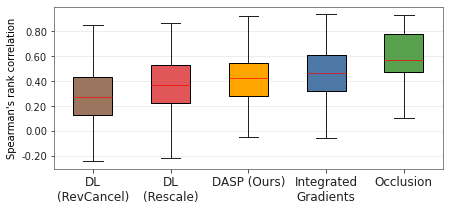

In [13]:
# from utils.utils import plot_mse_comparison, plot_correlation_comparison
        
plot_mse_comparison('spotifier',
                    [x[1] for x in attributions],
                    [x[0] for x in attributions],
                    gt_idx=-1)
plot_correlation_comparison('spotifier',
                        [x[1] for x in attributions],
                        [x[0] for x in attributions],
                        gt_idx=-1)

## Comparison of feature importance assigned by Integrated Gradients and DASP
We use the plot from (Lundberg et al., 2017) to visualize how features are attributed different importance values over the 100 samples we are considering. In the following plot, each dot is an individual in the dataset. Notice, for example, how Integrated Gradients overestimates the impact (positive or negative) of *age*.

In [14]:
""" Summary plots of SHAP values across a whole dataset.
Credits: https://github.com/slundberg/shap
"""

import warnings
import numpy as np
from scipy.stats import gaussian_kde
try:
    import matplotlib.pyplot as pl
except ImportError:
    pass
from shap.plots import _labels as labels
from shap.plots import colors
from matplotlib.colors import LinearSegmentedColormap

blue_rgba = np.array([62, 160, 198, 255]) / 255
blue_rgb = np.array([62, 160, 198]) / 255
red_rgb = np.array([197, 42, 57]) / 255

default_blue_colors = []
tmp = blue_rgba.copy()
for i in range(10):
    default_blue_colors.append(tmp.copy())
    if tmp[-1] > 0.1:
        tmp[-1] *= 0.7



red_blue = LinearSegmentedColormap('red_blue', { # #1E88E5 -> #ff0052
    'red': ((0.0, 62./255, 62./255),
            (1.0, 197./255, 197./255)),

    'green': ((0.0, 160./255, 160./255),
              (1.0, 42./255, 42./255)),

    'blue': ((0.0, 198./255, 198./255),
             (1.0, 57./255, 57./255)),

    'alpha': ((0.0, 1, 1),
              (0.5, 0.3, 0.3),
              (1.0, 1, 1))
})

red_blue_solid = LinearSegmentedColormap('red_blue_solid', {
    'red': ((0.0, 62. / 255, 62. / 255),
            (1.0, 197. / 255, 197. / 255)),

    'green': ((0.0, 160. / 255, 160. / 255),
              (1.0, 42. / 255, 42. / 255)),

    'blue': ((0.0, 198. / 255, 198. / 255),
             (1.0, 57. / 255, 57. / 255)),

    'alpha': ((0.0, 1, 1),
              (0.5, 1, 1),
              (1.0, 1, 1))
})

# TODO: remove unused title argument / use title argument
def summary_plot(shap_values, features=None, feature_names=None, max_display=None, plot_type="dot",
                 color=None, axis_color="#333333", title=None, alpha=1, show=True, sort=True,
                 color_bar=True, auto_size_plot=True, layered_violin_max_num_bins=20, class_names=None, limit=None):
    """Create a SHAP summary plot, colored by feature values when they are provided.

    Parameters
    ----------
    shap_values : numpy.array
        Matrix of SHAP values (# samples x # features)

    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand

    feature_names : list
        Names of the features (length # features)

    max_display : int
        How many top features to include in the plot (default is 20, or 7 for interaction plots)

    plot_type : "dot" (default) or "violin"
        What type of summary plot to produce
    """
    print (title)
    multi_class = False
    if isinstance(shap_values, list):
        multi_class = True
        plot_type = "bar" # only type supported for now
    else:
        assert len(shap_values.shape) != 1, "Summary plots need a matrix of shap_values, not a vector."

    # default color:
    if color is None:
        if plot_type == 'layered_violin':
            color = "coolwarm"
        elif multi_class:
            color = lambda i: default_blue_colors[min(i, len(default_blue_colors)-1)]
        else:
            color = "#1E88E5" #"#ff0052"

    # convert from a DataFrame or other types
    if str(type(features)) == "<class 'pandas.core.frame.DataFrame'>":
        if feature_names is None:
            feature_names = features.columns
        features = features.values
    elif isinstance(features, list):
        if feature_names is None:
            feature_names = features
        features = None
    elif (features is not None) and len(features.shape) == 1 and feature_names is None:
        feature_names = features
        features = None

    num_features = (shap_values[0].shape[1] if multi_class else shap_values.shape[1])

    if feature_names is None:
        feature_names = np.array([labels['FEATURE'] % str(i) for i in range(num_features)])

    # plotting SHAP interaction values
    if not multi_class and len(shap_values.shape) == 3:
        if max_display is None:
            max_display = 7
        else:
            max_display = min(len(feature_names), max_display)

        sort_inds = np.argsort(-np.abs(shap_values.sum(1)).sum(0))

        # get plotting limits
        delta = 1.0 / (shap_values.shape[1] ** 2)
        slow = np.nanpercentile(shap_values, delta)
        shigh = np.nanpercentile(shap_values, 100 - delta)
        v = max(abs(slow), abs(shigh))
        slow = -v
        shigh = v
        if limit is not None:
            slow = -limit
            shigh = limit
        print (slow)
        print (slow)
        pl.figure(figsize=(1.5 * max_display + 1, 0.8 * max_display + 1))
        pl.subplot(1, max_display, 1)
        proj_shap_values = shap_values[:, sort_inds[0], sort_inds]
        proj_shap_values[:, 1:] *= 2  # because off diag effects are split in half
        summary_plot(
            proj_shap_values, features[:, sort_inds] if features is not None else None,
            feature_names=feature_names[sort_inds],
            sort=False, show=False, color_bar=False,
            auto_size_plot=False,
            max_display=max_display
        )
        pl.xlim((slow, shigh))
        pl.xlabel("")
        title_length_limit = 11
        pl.title(shorten_text(feature_names[sort_inds[0]], title_length_limit))
        for i in range(1, min(len(sort_inds), max_display)):
            ind = sort_inds[i]
            pl.subplot(1, max_display, i + 1)
            proj_shap_values = shap_values[:, ind, sort_inds]
            proj_shap_values *= 2
            proj_shap_values[:, i] /= 2  # because only off diag effects are split in half
            summary_plot(
                proj_shap_values, features[:, sort_inds] if features is not None else None,
                sort=False,
                feature_names=["" for i in range(len(feature_names))],
                show=False,
                color_bar=False,
                auto_size_plot=False,
                max_display=max_display
            )
            pl.xlim((slow, shigh))
            pl.xlabel("")
            if i == min(len(sort_inds), max_display) // 2:
                pl.xlabel(labels['INTERACTION_VALUE'])
            pl.title(shorten_text(feature_names[ind], title_length_limit))
        pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)
        pl.subplots_adjust(hspace=0, wspace=0.1)
        if show:
            pl.show()
        return

    if max_display is None:
        max_display = 20

    if sort:
        # order features by the sum of their effect magnitudes
        if multi_class:
            feature_order = np.argsort(np.sum(np.mean(np.abs(shap_values), axis=0), axis=0))
        else:
            feature_order = np.argsort(np.sum(np.abs(shap_values), axis=0))
        feature_order = feature_order[-min(max_display, len(feature_order)):]
    else:
        feature_order = np.flip(np.arange(min(max_display, num_features)), 0)

    row_height = 0.4
    if auto_size_plot:
        pl.gcf().set_size_inches(8, len(feature_order) * row_height + 1.5)
    pl.axvline(x=0, color="#999999", zorder=-1)

    if plot_type == "dot":
        for pos, i in enumerate(feature_order):
            pl.axhline(y=pos, color="#cccccc", lw=0.5, dashes=(1, 5), zorder=-1)
            shaps = shap_values[:, i]
            values = None if features is None else features[:, i]
            inds = np.arange(len(shaps))
            np.random.shuffle(inds)
            if values is not None:
                values = values[inds]
            shaps = shaps[inds]
            colored_feature = True
            try:
                values = np.array(values, dtype=np.float64)  # make sure this can be numeric
            except:
                colored_feature = False
            N = len(shaps)
            # hspacing = (np.max(shaps) - np.min(shaps)) / 200
            # curr_bin = []
            nbins = 100
            quant = np.round(nbins * (shaps - np.min(shaps)) / (np.max(shaps) - np.min(shaps) + 1e-8))
            inds = np.argsort(quant + np.random.randn(N) * 1e-6)
            layer = 0
            last_bin = -1
            ys = np.zeros(N)
            for ind in inds:
                if quant[ind] != last_bin:
                    layer = 0
                ys[ind] = np.ceil(layer / 2) * ((layer % 2) * 2 - 1)
                layer += 1
                last_bin = quant[ind]
            ys *= 0.9 * (row_height / np.max(ys + 1))

            if features is not None and colored_feature:
                # trim the color range, but prevent the color range from collapsing
                vmin = np.nanpercentile(values, 5)
                vmax = np.nanpercentile(values, 95)
                if vmin == vmax:
                    vmin = np.nanpercentile(values, 1)
                    vmax = np.nanpercentile(values, 99)
                    if vmin == vmax:
                        vmin = np.min(values)
                        vmax = np.max(values)

                assert features.shape[0] == len(shaps), "Feature and SHAP matrices must have the same number of rows!"
                nan_mask = np.isnan(values)
                pl.scatter(shaps[nan_mask], pos + ys[nan_mask], color="#777777", vmin=vmin,
                           vmax=vmax, s=16, alpha=alpha, linewidth=0,
                           zorder=3, rasterized=len(shaps) > 500)
                pl.scatter(shaps[np.invert(nan_mask)], pos + ys[np.invert(nan_mask)],
                           cmap=red_blue, vmin=vmin, vmax=vmax, s=16,
                           c=values[np.invert(nan_mask)], alpha=alpha, linewidth=0,
                           zorder=3, rasterized=len(shaps) > 500)
            else:

                pl.scatter(shaps, pos + ys, s=16, alpha=alpha, linewidth=0, zorder=3,
                           color=color if colored_feature else "#777777", rasterized=len(shaps) > 500)
        if limit is not None:
            pl.xlim(-limit, limit)

    elif plot_type == "violin":
        for pos, i in enumerate(feature_order):
            pl.axhline(y=pos, color="#cccccc", lw=0.5, dashes=(1, 5), zorder=-1)

        if features is not None:
            global_low = np.nanpercentile(shap_values[:, :len(feature_names)].flatten(), 1)
            global_high = np.nanpercentile(shap_values[:, :len(feature_names)].flatten(), 99)
            for pos, i in enumerate(feature_order):
                shaps = shap_values[:, i]
                shap_min, shap_max = np.min(shaps), np.max(shaps)
                rng = shap_max - shap_min
                xs = np.linspace(np.min(shaps) - rng * 0.2, np.max(shaps) + rng * 0.2, 100)
                if np.std(shaps) < (global_high - global_low) / 100:
                    ds = gaussian_kde(shaps + np.random.randn(len(shaps)) * (global_high - global_low) / 100)(xs)
                else:
                    ds = gaussian_kde(shaps)(xs)
                ds /= np.max(ds) * 3

                values = features[:, i]
                window_size = max(10, len(values) // 20)
                smooth_values = np.zeros(len(xs) - 1)
                sort_inds = np.argsort(shaps)
                trailing_pos = 0
                leading_pos = 0
                running_sum = 0
                back_fill = 0
                for j in range(len(xs) - 1):

                    while leading_pos < len(shaps) and xs[j] >= shaps[sort_inds[leading_pos]]:
                        running_sum += values[sort_inds[leading_pos]]
                        leading_pos += 1
                        if leading_pos - trailing_pos > 20:
                            running_sum -= values[sort_inds[trailing_pos]]
                            trailing_pos += 1
                    if leading_pos - trailing_pos > 0:
                        smooth_values[j] = running_sum / (leading_pos - trailing_pos)
                        for k in range(back_fill):
                            smooth_values[j - k - 1] = smooth_values[j]
                    else:
                        back_fill += 1

                vmin = np.nanpercentile(values, 5)
                vmax = np.nanpercentile(values, 95)
                if vmin == vmax:
                    vmin = np.nanpercentile(values, 1)
                    vmax = np.nanpercentile(values, 99)
                    if vmin == vmax:
                        vmin = np.min(values)
                        vmax = np.max(values)
                pl.scatter(shaps, np.ones(shap_values.shape[0]) * pos, s=9, cmap=red_blue_solid, vmin=vmin, vmax=vmax,
                           c=values, alpha=alpha, linewidth=0, zorder=1)
                # smooth_values -= nxp.nanpercentile(smooth_values, 5)
                # smooth_values /= np.nanpercentile(smooth_values, 95)
                smooth_values -= vmin
                if vmax - vmin > 0:
                    smooth_values /= vmax - vmin
                for i in range(len(xs) - 1):
                    if ds[i] > 0.05 or ds[i + 1] > 0.05:
                        pl.fill_between([xs[i], xs[i + 1]], [pos + ds[i], pos + ds[i + 1]],
                                        [pos - ds[i], pos - ds[i + 1]], color=red_blue_solid(smooth_values[i]),
                                        zorder=2)

        else:
            parts = pl.violinplot(shap_values[:, feature_order], range(len(feature_order)), points=200, vert=False,
                                  widths=0.7,
                                  showmeans=False, showextrema=False, showmedians=False)

            for pc in parts['bodies']:
                pc.set_facecolor(color)
                pc.set_edgecolor('none')
                pc.set_alpha(alpha)

    elif plot_type == "layered_violin":  # courtesy of @kodonnell
        num_x_points = 200
        bins = np.linspace(0, features.shape[0], layered_violin_max_num_bins + 1).round(0).astype(
            'int')  # the indices of the feature data corresponding to each bin
        shap_min, shap_max = np.min(shap_values), np.max(shap_values)
        x_points = np.linspace(shap_min, shap_max, num_x_points)

        # loop through each feature and plot:
        for pos, ind in enumerate(feature_order):
            # decide how to handle: if #unique < layered_violin_max_num_bins then split by unique value, otherwise use bins/percentiles.
            # to keep simpler code, in the case of uniques, we just adjust the bins to align with the unique counts.
            feature = features[:, ind]
            unique, counts = np.unique(feature, return_counts=True)
            if unique.shape[0] <= layered_violin_max_num_bins:
                order = np.argsort(unique)
                thesebins = np.cumsum(counts[order])
                thesebins = np.insert(thesebins, 0, 0)
            else:
                thesebins = bins
            nbins = thesebins.shape[0] - 1
            # order the feature data so we can apply percentiling
            order = np.argsort(feature)
            # x axis is located at y0 = pos, with pos being there for offset
            y0 = np.ones(num_x_points) * pos
            # calculate kdes:
            ys = np.zeros((nbins, num_x_points))
            for i in range(nbins):
                # get shap values in this bin:
                shaps = shap_values[order[thesebins[i]:thesebins[i + 1]], ind]
                # if there's only one element, then we can't
                if shaps.shape[0] == 1:
                    warnings.warn(
                        "not enough data in bin #%d for feature %s, so it'll be ignored. Try increasing the number of records to plot."
                        % (i, feature_names[ind]))
                    # to ignore it, just set it to the previous y-values (so the area between them will be zero). Not ys is already 0, so there's
                    # nothing to do if i == 0
                    if i > 0:
                        ys[i, :] = ys[i - 1, :]
                    continue
                # save kde of them: note that we add a tiny bit of gaussian noise to avoid singular matrix errors
                ys[i, :] = gaussian_kde(shaps + np.random.normal(loc=0, scale=0.001, size=shaps.shape[0]))(x_points)
                # scale it up so that the 'size' of each y represents the size of the bin. For continuous data this will
                # do nothing, but when we've gone with the unqique option, this will matter - e.g. if 99% are male and 1%
                # female, we want the 1% to appear a lot smaller.
                size = thesebins[i + 1] - thesebins[i]
                bin_size_if_even = features.shape[0] / nbins
                relative_bin_size = size / bin_size_if_even
                ys[i, :] *= relative_bin_size
            # now plot 'em. We don't plot the individual strips, as this can leave whitespace between them.
            # instead, we plot the full kde, then remove outer strip and plot over it, etc., to ensure no
            # whitespace
            ys = np.cumsum(ys, axis=0)
            width = 0.8
            scale = ys.max() * 2 / width  # 2 is here as we plot both sides of x axis
            for i in range(nbins - 1, -1, -1):
                y = ys[i, :] / scale
                c = pl.get_cmap(color)(i / (
                        nbins - 1)) if color in pl.cm.datad else color  # if color is a cmap, use it, otherwise use a color
                pl.fill_between(x_points, pos - y, pos + y, facecolor=c)
        if limit is None:
            pl.xlim(shap_min, shap_max)
        else:
            pl.xlim(-limit, limit)

    elif not multi_class and plot_type == "bar":
        feature_inds = feature_order[:max_display]
        y_pos = np.arange(len(feature_inds))
        global_shap_values = np.abs(shap_values).mean(0)
        pl.barh(y_pos, global_shap_values[feature_inds], 0.7, align='center', color=color)
        pl.yticks(y_pos, fontsize=13)
        pl.gca().set_yticklabels([feature_names[i] for i in feature_inds])

    elif multi_class and plot_type == "bar":
        if class_names is None:
            class_names = ["Class "+str(i) for i in range(len(shap_values))]
        feature_inds = feature_order[:max_display]
        y_pos = np.arange(len(feature_inds))
        left_pos = np.zeros(len(feature_inds))

        class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
        for i,ind in enumerate(class_inds):
            global_shap_values = np.abs(shap_values[ind]).mean(0)
            pl.barh(
                y_pos, global_shap_values[feature_inds], 0.7, left=left_pos, align='center',
                color=color(i), label=class_names[ind]
            )
            left_pos += global_shap_values[feature_inds]
        pl.yticks(y_pos, fontsize=13)
        pl.gca().set_yticklabels([feature_names[i] for i in feature_inds])
        pl.legend(frameon=False, fontsize=12)

    # draw the color bar
    if color_bar and features is not None and plot_type != "bar" and \
            (plot_type != "layered_violin" or color in pl.cm.datad):
        import matplotlib.cm as cm
        m = cm.ScalarMappable(cmap=red_blue_solid if plot_type != "layered_violin" else pl.get_cmap(color))
        m.set_array([0, 1])
        cb = pl.colorbar(m, ticks=[0, 1], aspect=1000)
        cb.set_ticklabels(['LOW', 'HIGH'])
        cb.set_label('FEATURE VALUE', size=12, labelpad=0)
        cb.ax.tick_params(labelsize=11, length=0)
        cb.set_alpha(1)
        cb.outline.set_visible(False)
        bbox = cb.ax.get_window_extent().transformed(pl.gcf().dpi_scale_trans.inverted())
        cb.ax.set_aspect((bbox.height - 0.9) * 20)
        # cb.draw_all()

    pl.gca().xaxis.set_ticks_position('bottom')
    pl.gca().yaxis.set_ticks_position('none')
    pl.gca().spines['right'].set_visible(False)
    pl.gca().spines['top'].set_visible(False)
    pl.gca().spines['left'].set_visible(False)
    pl.gca().tick_params(color=axis_color, labelcolor=axis_color)
    pl.yticks(range(len(feature_order)), [feature_names[i] for i in feature_order], fontsize=13)
    if plot_type != "bar":
        pl.gca().tick_params('y', length=20, width=0.5, which='major')
    pl.gca().tick_params('x', labelsize=11)
    pl.ylim(-1, len(feature_order))
    if plot_type == "bar":
        pl.xlabel(labels['GLOBAL_VALUE'], fontsize=13)
    else:
        pl.xlabel("Feature assigned attribution", fontsize=13)
    if show:
        pl.savefig('./results/spotifier/' + title + '.pdf', bbox_inches = "tight")
        pl.show()


def shorten_text(text, length_limit):
    if len(text) > length_limit:
        return text[:length_limit - 3] + "..."
    else:
        return text


Exact


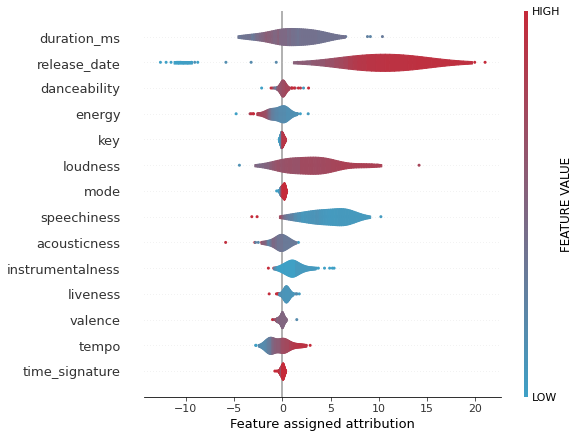

DASP


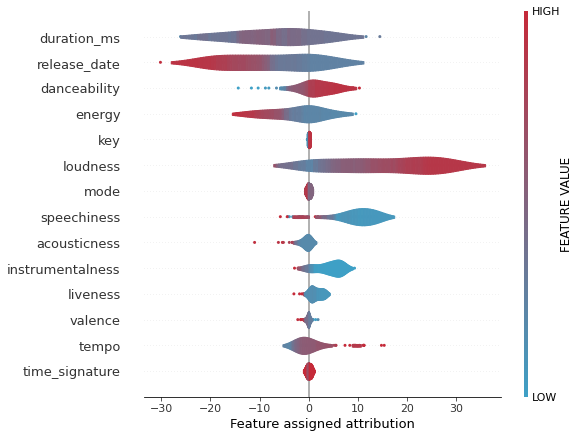

Integrated Gradients


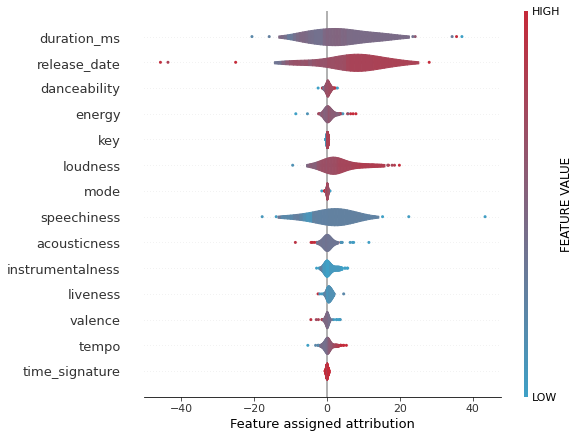

In [15]:
# from utils.summary_plot import summary_plot
feat_names = ['duration_ms', 'release_date', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

summary_plot(a_exact[:, :], xs, feat_names,plot_type="violin", sort=False, limit=30, title="Exact")
summary_plot(a_dasp[:, 0, :], xs, feat_names, plot_type="violin", sort=False, limit=30, title="DASP")
summary_plot(a_intgrad, xs, feat_names, plot_type="violin", sort=False, limit=30, title='Integrated Gradients')